# Kidney CT Scan Dataset: Multimodal Patch-Based GNN for Normal, Cyst, Tumor, and Stone Classification

## Project Description

This project leverages a curated dataset of kidney CT scans collected from multiple diagnostic centers in Dhaka, Bangladesh. The images are categorized into four diagnostic classes:

- **Normal**
- **Cyst**
- **Tumor**
- **Stone**

The primary objective is to implement a **Graph Neural Network (GNN)** model that integrates both **visual features** from the images and **semantic features** derived from medical text to improve classification of kidney conditions.

### Multimodal Design

Each image is divided into smaller patches (e.g., a 4x4 grid). These patches are:
- Processed through a **Convolutional Neural Network (CNN)**, specifically a pretrained **ResNet18**, to extract deep features from each patch.
- Treated as individual **nodes** in a graph, capturing spatial and text-interconnected relationships.

Additionally, each image is paired with a corresponding **domain-informed text description**, such as:
> “Contrast-enhanced CT shows a solid irregular renal mass indicating a tumor.”

These text descriptions are embedded using language models like **BioBERT** or **CLIP**, and included as **text nodes** in the same graph structure.

The resulting graph per image contains:
- **Patch nodes** (image regions)
- **One text node**
- **Edges** representing spatial proximity and semantic relationships

A GNN model (e.g., **Graph Attention Network (GAT)** or **GraphSAGE**) processes this structure to learn complex interactions between image regions and associated diagnostic language, followed by a **global pooling layer** and **multi-layer perceptron (MLP)** for final classification.


## Class Descriptions

- **Normal**: CT scans displaying healthy kidney tissues without visible abnormalities. These serve as a reference baseline.

- **Cyst**: CT images revealing fluid-filled sacs, typically benign, but clinically relevant due to potential complications such as rupture or infection.

- **Tumor**: Scans showing irregular masses that may indicate malignancies like renal cell carcinoma. Tumors are characterized by their shape, density, and contrast uptake.

- **Stone**: Highly radiodense structures representing calcified mineral deposits in the renal system. These may cause pain, obstructions, or urinary tract infections.


## Significance

This multimodal GNN approach demonstrates how **spatial, semantic, and visual information** can be combined to advance automated kidney disease diagnosis. It has the potential to:
- Improve detection accuracy
- Assist radiologists with clinical decision-making
- Serve as a foundation for computer-aided detection (CAD) systems in medical imaging


## 1. Dataset Preparation

In [90]:
import pandas as pd
import os

csv_path = r"C:\Users\glori\Desktop\Fundamentals of Big Data Analytics\GNN Multimodal analysis\dataset_with_text.csv"

df = pd.read_csv(csv_path)
print("✅ Dataset loaded.")
print(df.head())

✅ Dataset loaded.
   Unnamed: 0       image_id  \
0           0  Tumor- (1044)   
1           1    Tumor- (83)   
2           2   Tumor- (580)   
3           3  Tumor- (1701)   
4           4  Tumor- (1220)   

                                                path   diag  target  Class  \
0  C:\Users\glori\Desktop\Fundamentals of Big Dat...  Tumor       3  Tumor   
1  C:\Users\glori\Desktop\Fundamentals of Big Dat...  Tumor       3  Tumor   
2  C:\Users\glori\Desktop\Fundamentals of Big Dat...  Tumor       3  Tumor   
3  C:\Users\glori\Desktop\Fundamentals of Big Dat...  Tumor       3  Tumor   
4  C:\Users\glori\Desktop\Fundamentals of Big Dat...  Tumor       3  Tumor   

                                    text_description  
0  Contrast-enhanced CT shows a solid irregular r...  
1  Contrast-enhanced CT shows a solid irregular r...  
2  Contrast-enhanced CT shows a solid irregular r...  
3  Contrast-enhanced CT shows a solid irregular r...  
4  Contrast-enhanced CT shows a solid irregul

In [91]:
df['path_exists'] = df['path'].apply(lambda x: os.path.exists(x))

missing_count = (~df['path_exists']).sum()
if missing_count > 0:
    print(f"{missing_count} images have broken paths.")
    print(df[df['path_exists'] == False][['image_id', 'path']].head())
else:
    print("✅ All image paths are valid.")

✅ All image paths are valid.


## Patch-Based CNN Feature Extraction (ResNet18)

- load each image

- Divide the images into a 4x4 grid (16 patches)

- Extract a 512-dimensional feature vecor from each patch using ResNet18

- Save the result in a Numpy file for use in GNN graph creation

In [95]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm

### Load ResNet18 pretrained on ImageNet, remove final FC layer

In [96]:
resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove classification head
resnet.eval()

C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

## Image Processing

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize whole image 
    transforms.ToTensor()
])

### Patch extraction

In [ ]:
grid_size = 4  
patch_features = []

print("📦 Extracting patch features using ResNet18...")

for _, row in tqdm(df.iterrows(), total=len(df)):
    try:
        image_path = row["path"]
        img = Image.open(image_path).convert("RGB")
        img = transform(img)

        # Get patch size
        C, H, W = img.shape
        patch_H = H // grid_size
        patch_W = W // grid_size

        patches = []
        for i in range(grid_size):
            for j in range(grid_size):
                top = i * patch_H
                left = j * patch_W
                patch = img[:, top:top + patch_H, left:left + patch_W]
                patch = patch.unsqueeze(0)  # Add batch dim

                with torch.no_grad():
                    feature = resnet(patch).squeeze().numpy()  # Shape: (512,)
                patches.append(feature)

        patch_features.append(patches)

    except Exception as e:
        print(f"Error processing {row['image_id']}: {e}")
        patch_features.append([np.zeros(512)] * (grid_size * grid_size))

# Convert to NumPy array and save
patch_features = np.array(patch_features)  # Shape: [N, 16, 512]
np.save("patch_features.npy", patch_features)
print("✅ Feature extraction complete. Saved to 'patch_features.npy'.")

📦 Extracting patch features using ResNet18...


100%|██████████| 12446/12446 [1:01:42<00:00,  3.36it/s]


✅ Feature extraction complete. Saved to 'patch_features.npy'.


OUTPUT

- 16 nodes per image (1 node per patch)

- Feature vectors for each node

- A foundation to build a graph structure (connect patches, add a text node)



## Text Embedding

### Embed text_description

#### Spark Text Preprocessing (Lowercase, Clean Punctuation)

In [ ]:
# PySpark code to clean text_description column

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace

# Initialize Spark session
spark = SparkSession.builder.appName("TextClean").getOrCreate()

# Load CSV with original text_description
csv_path = r"C:\Users\glori\Desktop\Fundamentals of Big Data Analytics\GNN Multimodal analysis\dataset_with_text.csv"
df = spark.read.csv(csv_path, header=True)

# Clean the text: lowercase + remove non-word characters
df_cleaned = df.withColumn(
    "text_description",
    regexp_replace(lower(col("text_description")), r"[^\w\s]", "")
)

# Show sample
df_cleaned.select("text_description").show(5, truncate=False)

# Save cleaned version back to CSV
cleaned_csv_path = r"C:\Users\glori\Desktop\Fundamentals of Big Data Analytics\GNN Multimodal analysis\cleaned_dataset.csv"
df_cleaned.toPandas().to_csv(cleaned_csv_path, index=False)


#### Text Embedding with sentence-transformers

In [ ]:
# Python code to compute text embeddings
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from tqdm import tqdm

# Load cleaned dataset
csv_path = r"C:\Users\glori\Desktop\Fundamentals of Big Data Analytics\GNN Multimodal analysis\cleaned_dataset.csv"
df = pd.read_csv(csv_path)

# Load MiniLM model (fast + good for semantic embeddings)
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Embed descriptions
descriptions = df["text_description"].fillna("No description").tolist()
print("🔤 Embedding text_descriptions...")
embeddings = model.encode(descriptions, show_progress_bar=True)

# Save embeddings to .npy
np.save("text_embeddings_sbert.npy", embeddings)
print("✅ Saved to text_embeddings_sbert.npy")
print(f"Embedding shape: {embeddings.shape}")


## graph construction pipeline using torch_geometric

- patch_features.npy → shape: (N, 16, 512) → 16 patch nodes per image

- text_embeddings_sbert.npy → shape: (N, 384) → 1 text node per image

In [99]:
import numpy as np
import torch
from torch_geometric.data import Data

In [1]:
import torch
import numpy as np
import pandas as pd
from torch_geometric.data import Data

df = pd.read_csv(r"C:\Users\glori\Desktop\Fundamentals of Big Data Analytics\GNN Multimodal analysis\cleaned_dataset.csv")

# Load features
patch_features = np.load("patch_features.npy")  # [N, 16, 512]
text_embeddings = np.load("text_embeddings_sbert.npy")  # [N, 384]

# Ensure shapes align
assert patch_features.shape[0] == text_embeddings.shape[0], "Mismatch in number of samples!"

num_samples = patch_features.shape[0]
patch_dim = patch_features.shape[2]

graph_list = []

for i in range(num_samples):
    patch_nodes = patch_features[i]
    text_node = text_embeddings[i].reshape(1, -1)

    if text_node.shape[1] != patch_nodes.shape[1]:
        padded_text = np.zeros((1, patch_nodes.shape[1]))
        padded_text[:, :text_node.shape[1]] = text_node
        text_node = padded_text

    x = np.vstack([patch_nodes, text_node])
    x = torch.tensor(x, dtype=torch.float)

    # Edge construction
    edge_index = []
    grid_size = 4
    for row in range(grid_size):
        for col in range(grid_size):
            idx = row * grid_size + col
            if col < grid_size - 1:
                edge_index.append([idx, idx + 1])
                edge_index.append([idx + 1, idx])
            if row < grid_size - 1:
                edge_index.append([idx, idx + grid_size])
                edge_index.append([idx + grid_size, idx])
    for idx in range(16):
        edge_index.append([idx, 16])
        edge_index.append([16, idx])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Add label from DataFrame
    label = df.iloc[i]["target"]
    data = Data(x=x, edge_index=edge_index, y=torch.tensor(label, dtype=torch.long))
    graph_list.append(data)

# Save graph dataset
graph_dataset = graph_list
print(f"✅ Created {len(graph_dataset)} multimodal graphs with labels.")


✅ Created 12446 multimodal graphs with labels.


In [2]:
graph_dataset = graph_list

In [3]:
# Pick a sample graph (e.g., first one)
data = graph_list[0]

# Summary of the graph
print(data)
print(f"Number of nodes: {data.num_nodes}")
print(f"Edge index shape: {data.edge_index.shape}")
print(f"Node feature shape: {data.x.shape}")

Data(x=[17, 512], edge_index=[2, 80], y=3)
Number of nodes: 17
Edge index shape: torch.Size([2, 80])
Node feature shape: torch.Size([17, 512])


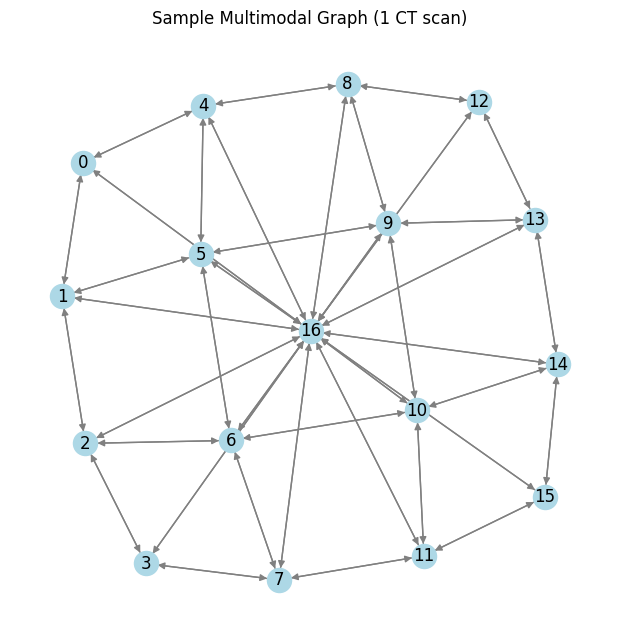

In [104]:
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import networkx as nx

# Convert to NetworkX for visualization
G = to_networkx(data)

# Plot graph
plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title("Sample Multimodal Graph (1 CT scan)")
plt.show()


# GNN Model

### GNN Model Definition

In [52]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_max_pool

class GCNGraphClassifier(torch.nn.Module):
    def __init__(self, in_channels=512, hidden_channels=64, num_classes=4):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_max_pool(x, batch)
        return self.lin(x)


### Setup Model, Optimizer, and DataLoader

In [ ]:
import torch
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split

# Class distribution from your dataset (based on previous counts)
class_counts = torch.tensor([3709, 5077, 1377, 2283], dtype=torch.float)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()  # Normalize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, optimizer, loss with class weights
model = GCNGraphClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

# Rebuild train/test split
labels = [data.y.item() for data in graph_list]
train_idx, test_idx = train_test_split(
    list(range(len(graph_list))),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

train_dataset = [graph_list[i] for i in train_idx]
test_dataset = [graph_list[i] for i in test_idx]

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [54]:
from collections import Counter
print("Full:", Counter(labels))
print("Train:", Counter([data.y.item() for data in train_dataset]))
print("Test:", Counter([data.y.item() for data in test_dataset]))


Full: Counter({1: 5077, 0: 3709, 3: 2283, 2: 1377})
Train: Counter({1: 4061, 0: 2967, 3: 1826, 2: 1102})
Test: Counter({1: 1016, 0: 742, 3: 457, 2: 275})


### Training & Evaluation Functions

In [55]:
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset)


In [56]:
train_losses = []

for epoch in range(1, 21):
    loss = train()
    acc = test(test_loader)
    train_losses.append(loss)
    print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Test Acc: {acc:.4f}")

Epoch 01 | Loss: 0.8196 | Test Acc: 0.8486
Epoch 02 | Loss: 0.3002 | Test Acc: 0.9016
Epoch 03 | Loss: 0.1443 | Test Acc: 0.9703
Epoch 04 | Loss: 0.0894 | Test Acc: 0.9791
Epoch 05 | Loss: 0.0552 | Test Acc: 0.9948
Epoch 06 | Loss: 0.0361 | Test Acc: 0.9880
Epoch 07 | Loss: 0.0629 | Test Acc: 0.9980
Epoch 08 | Loss: 0.0428 | Test Acc: 0.9944
Epoch 09 | Loss: 0.0138 | Test Acc: 0.9908
Epoch 10 | Loss: 0.0387 | Test Acc: 0.9984
Epoch 11 | Loss: 0.0145 | Test Acc: 0.8245
Epoch 12 | Loss: 0.0329 | Test Acc: 0.9904
Epoch 13 | Loss: 0.0156 | Test Acc: 0.9988
Epoch 14 | Loss: 0.0408 | Test Acc: 0.9988
Epoch 15 | Loss: 0.0016 | Test Acc: 1.0000
Epoch 16 | Loss: 0.0005 | Test Acc: 0.9996
Epoch 17 | Loss: 0.0004 | Test Acc: 1.0000
Epoch 18 | Loss: 0.0410 | Test Acc: 0.9988
Epoch 19 | Loss: 0.0080 | Test Acc: 0.9996
Epoch 20 | Loss: 0.0022 | Test Acc: 0.9908


## Evaluation

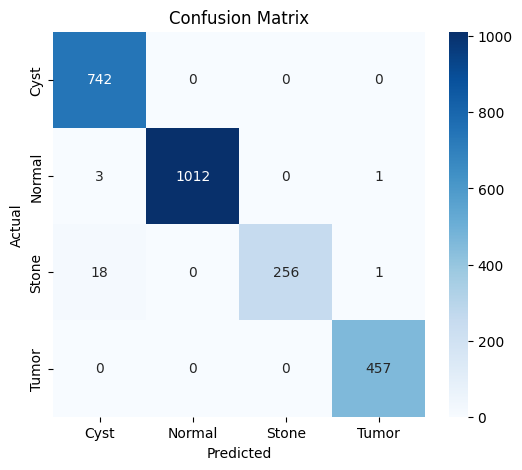

In [57]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Collect true and predicted labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        preds = out.argmax(dim=1).cpu().numpy()
        labels = data.y.cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Cyst", "Normal", "Stone", "Tumor"],
            yticklabels=["Cyst", "Normal", "Stone", "Tumor"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Classification report

In [ ]:
print(classification_report(all_labels, all_preds, target_names=["Cyst", "Normal", "Stone", "Tumor"]))

              precision    recall  f1-score   support

        Cyst       0.97      1.00      0.99       742
      Normal       1.00      1.00      1.00      1016
       Stone       1.00      0.93      0.96       275
       Tumor       1.00      1.00      1.00       457

    accuracy                           0.99      2490
   macro avg       0.99      0.98      0.99      2490
weighted avg       0.99      0.99      0.99      2490



### ROC Curve

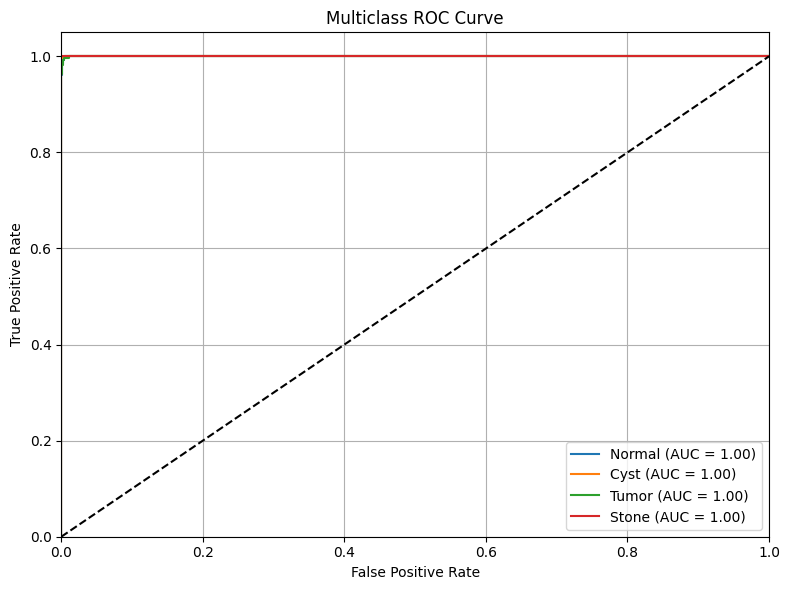

In [59]:
import torch
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np


class_names = ["Normal", "Cyst", "Tumor", "Stone"]
n_classes = len(class_names)

# Collect predictions and labels
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        probs = torch.softmax(out, dim=1).cpu().numpy()
        labels = data.y.cpu().numpy()

        all_probs.append(probs)
        all_labels.extend(labels)

# Convert to arrays
all_probs = np.vstack(all_probs)
all_labels = np.array(all_labels)

# Binarize labels for multiclass ROC
y_true_bin = label_binarize(all_labels, classes=np.arange(n_classes))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


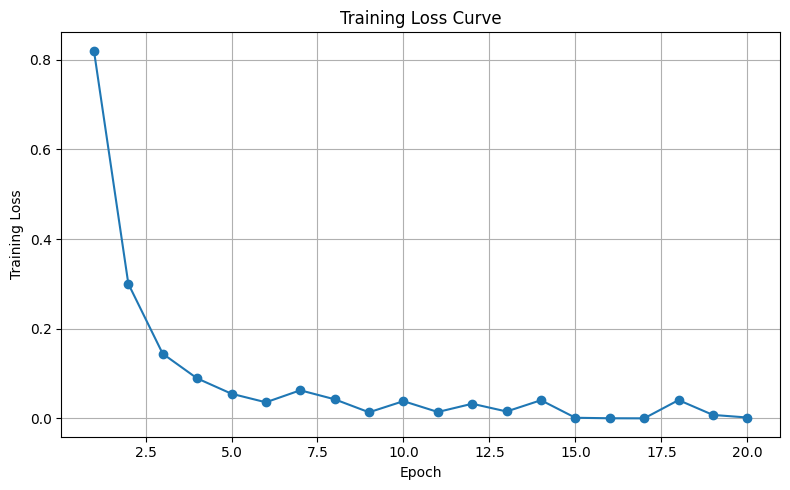

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.tight_layout()
plt.show()


# Grad-CAM Integration for GCNGraphClassifier


### 1. Register Hooks

In [61]:
# Hook storage
activations = {}
gradients = {}

def forward_hook(module, input, output):
    activations['value'] = output.detach()

def backward_hook(module, grad_input, grad_output):
    gradients['value'] = grad_output[0].detach()

# Register hooks on the second GCN layer
model.conv2.register_forward_hook(forward_hook)
model.conv2.register_backward_hook(backward_hook)


### 2. Run One Sample Through the Model

In [ ]:
data = test_dataset[0].to(device)

model.eval()

# Forward pass
output = model(data.x, data.edge_index, data.batch)
pred_class = output.argmax(dim=1).item()

# Backward pass
model.zero_grad()
class_loss = output[0, pred_class]  # Target class score
class_loss.backward()


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


### 3. Compute Grad-CAM Heatmap

In [63]:
# Get activation maps and gradients
acts = activations['value']         # shape: [num_nodes, hidden_channels]
grads = gradients['value']          # shape: [num_nodes, hidden_channels]

# Compute global average of gradients per feature channel
weights = grads.mean(dim=0)         # shape: [hidden_channels]

# Compute Grad-CAM by weighing activations
cam = (acts * weights).sum(dim=1)   # shape: [num_nodes]
cam = cam.cpu().numpy()

# Normalize CAM values for visualization
cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-6)

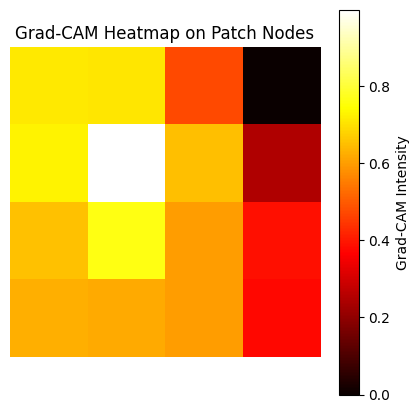

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Reshape first 16 node CAMs into a 4x4 grid
patch_cam = cam[:16].reshape(4, 4)

plt.figure(figsize=(5, 5))
plt.imshow(patch_cam, cmap='hot', interpolation='nearest')
plt.colorbar(label="Grad-CAM Intensity")
plt.title("Grad-CAM Heatmap on Patch Nodes")
plt.axis("off")
plt.show()


In [65]:
print(f"Text node CAM value: {cam[16]:.4f}")


Text node CAM value: 0.9830


#### Conclusion and Future Directions

From this analysis, it's evident that the **influence of the text node (clinical description)** on model decision-making is **class-dependent**. Notably:

- The **"Normal"** class consistently demonstrated **strong Grad-CAM activation** from the text node when correctly classified, suggesting that the model **relies heavily on textual features** for this class.
- Conversely, the **"Stone"** and **"Tumor"** classes showed **no correct predictions**, and their Grad-CAM activations were inconsistent. This may indicate that the current text embeddings **lack discriminative power** for these pathologies.
- The **"Cyst"** class displayed a reverse trend, where correct predictions had **lower CAM values**, implying that image features alone may suffice for its classification.

These insights suggest that while multimodal integration using superpixel-based graphs and text embeddings is promising, **the quality and informativeness of the text features vary by diagnosis type**.

Future Directions
- **Explore richer textual metadata** (e.g., radiologist notes or patient history) to enhance text node representations.
- Investigate **attention-based GNNs** (like GAT) or **transformer-based multimodal architectures** to better capture cross-modal dependencies.
- Conduct **finer-grained ablation studies** to quantify the specific contributions of image and text modalities per class.

This project has provided a strong foundation for understanding **interpretable multimodal graph learning** and opens the door to more nuanced and clinically meaningful model development.